In [ ]:
# final steps for preprocessing
# get rid of NaN trancript values DONE
# check the ground truth for subject numbers/ difference values DONE(new subjects added)
# if we can how do we validate the JA alignment better? 

In [2]:
# headers
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt
import scipy.io
import traceback

### Gather transcription data across experiments 12, 15, 351

In [2]:
def merge_transcription(df, gap):
    merged = []

    i = 0
    while i != df.index[-1]:
        try:
            final_utterance = df.loc[i, "utterance"]
        except:
            print(df.head(5))
        j = i
        onset = df.loc[i, "onset"]
        #print()
        while True and j != df.index[-1]:
            #print(df.loc[j, "offset"], df.loc[j+1, "onset"])
            diff = abs(df.loc[j, "offset"] - df.loc[j+1, "onset"])
            

            if diff >= gap:
                offset = df.loc[j, "offset"]
                
                if j != i:
                    #test += 1
                    pass
         
                # this is when you merge everythig eg the base case 
                final_utterance = (onset, offset, final_utterance)
                merged.append(final_utterance)
                
                i = j
                break
            final_utterance += " " + df.loc[j+1, "utterance"] 
            j += 1
        i += 1
    return pd.DataFrame(merged, columns=["onset", "offset", "utterance"])



In [3]:
def read_transcription(ind_subject, subject_folder, subject_id):
    ind_trans = ind_subject + f"\\speech_transcription_p\\speech_{subject_id}.txt"


    if not os.path.isfile(ind_trans):
        print("no speech transcription found for subject " + subject_id)
        return None
    else:
        
        try: 
            relative_speechTime = os.path.join(ind_subject, subject_folder+"_info.mat")
            speechTime = scipy.io.loadmat(relative_speechTime)
            speechTime = float(speechTime["trialInfo"]["speechTime"][0][0].squeeze())

        except Exception as e:
            print(e)
            return None
        
        df_cur = pd.read_csv(ind_trans, delimiter='\t', names=["onset","offset","utterance"])
        df_cur["onset"] += speechTime
        df_cur["offset"] += speechTime

        df_cur = df_cur[df_cur["utterance"].notnull()]
        df_cur = df_cur.reset_index(drop=True)

    return df_cur

In [4]:
def overlap(a0, b0, a1, b1):
    if (b0 <= a1) | (b1 <= a0):
        return False
    elif (a0 <= a1) & (b0 > a1):
        return True
    elif (a0 > a1) & (b1 > a0):
        return True
    else:
        return False

In [5]:
# Using the helper function overlap takes in the onset and offset
# of the utterances and matches them to those of JA
def align(u1, u2, JA):
    
    if len(JA) > 0:
        j1, j2 = JA[0][:2]
        
        if overlap(j1, j2, u1, u2):
            #plot_overlap(a0, b0, a1, b1)
            return 1
        elif j2 < u1:
            JA.pop(0)
    return 0

In [6]:
def get_JA(df_cur, ind_subject):

    df_cur["JA"] = np.nan
    var_string = os.path.join(ind_subject, "derived", "cevent_eye_joint-attend_both.mat")
        
    try: 
        JA = scipy.io.loadmat(var_string)
        JA = JA["sdata"]["data"][0][0].tolist()
        
        for i in df_cur.index:
            u1, u2 = df_cur.loc[i, ["onset", "offset"]]
            #print(u1, u2)
            attention = align(u1, u2, JA) 
            #print(attention)
            df_cur.loc[i, "JA"] = attention
            
    except Exception as e:
        print(e)
        

In [7]:
objects = ["helmet", "house","bluecar","rose","elephant","snowman","rabbit","spongebob","turtle","hammer",
         "ladybug","mantis","greencar","saw","doll","phone","rubiks","shovel","bigwheels","whitecar",
         "ladybugstick","purpleblock","bed","clearblock","bison","croc","drop","kettle","koala","lemon",
         "mango","moose","pot","seal","kettle","cat","potato","firetruck","bulldozer","car","ostrich",
         "frog","truck","lobster","carrot","colander","motorcycle","cup","dog","elephant","spaceship",
         "pineapple","banana","submarine","boat","cookie","stingray","fork","helicopter","duck","bee"]

def replace(utterance):
    for object in objects:
        utterance = utterance.replace(object, "toy")
    return utterance 

In [8]:
df_0 = pd.DataFrame(data= np.zeros((1,5)), columns=["exp","sub","onset","offset","utterance"])
df_prev = df_0
gap = 2

for exp in [12, 15, 351]:
    ind = f"M:\\experiment_{exp}\\included\\"

    for subject in os.listdir(ind):

        # match the subject number from the folder name
        match = re.search(r"\d{8}[_]\d{5}$", subject)
        if match == None:
            continue
        subject_folder = match.group()

        # get meta data 
        subject_folder = "__" + subject_folder
        subject_id = subject_folder.split("_")[-1]
        ind_subject = ind + subject_folder

        # read transcription 
        df_cur = read_transcription(ind_subject, subject_folder, subject_id)

        # an error occured while reading the transription
        # move on to the next subject 
        if type(df_cur) == type(None):
            continue 

        # transform the data by merging utterances based on a 2 sec gap, 
        df_cur = merge_transcription(df_cur, gap)
        # change all toys to toy
        #df_cur["utterance"] = df_cur["utterance"].apply(replace)
        # align JA with utterance onset/offset
        get_JA(df_cur, ind_subject)

        # set metadata and pointers for next iteration 
        df_cur["exp"] = exp
        df_cur["sub"] = subject_folder[2:]
    
        df_concat = pd.concat([df_prev, df_cur], ignore_index=True)
        df_prev = df_concat
            
trans_file = df_prev[(df_prev["onset"] > 0) & (df_prev["offset"] > 0)]
trans_file.to_csv("C:\\space\\elton\\UT\\TextAnalysis\\transcript_embeddings\\data\\exp_12_15_351_utterances_processed_noReplace.csv", index=False)

[Errno 2] No such file or directory: 'M:\\experiment_12\\included\\__20160225_17406\\derived\\cevent_eye_joint-attend_both.mat'
no speech transcription found for subject 17878
[Errno 2] No such file or directory: 'M:\\experiment_12\\included\\__20171012_19694\\derived\\cevent_eye_joint-attend_both.mat'
no speech transcription found for subject 20510
no speech transcription found for subject 21501
[Errno 2] No such file or directory: 'M:\\experiment_15\\included\\__20180725_21960\\derived\\cevent_eye_joint-attend_both.mat'
no speech transcription found for subject 24842


### Summary statistics 

In [52]:
# get number of subjects 
df.drop_duplicates(subset="sub").groupby(by="exp").size()

exp
12.0     37
15.0     52
351.0    29
dtype: int64

In [3]:
dfu = pd.read_csv("C:\\space\\elton\\UT\\TextAnalysis\\transcript_embeddings\\data\\exp_12_15_351_utterances.csv")
df = pd.read_csv("C:\\space\\elton\\UT\\TextAnalysis\\transcript_embeddings\\data\\exp_12_15_351_utterances_processed.csv")

In [4]:
def data_summary(df):

    median = df["utterance"].str.len().median()
    mean = df["utterance"].str.len().mean()

    sub_num = df["sub"].unique().shape[0]
    utterance_count_sub_mean = df.groupby("sub").count().mean()[1]

    print(f"Median utterance length: {median}")
    print(f"Mean utterance length: {mean}")
    print(f"There are {sub_num} subjects in our dataset")
    print(f"The average subject has around {utterance_count_sub_mean} utterances\n")

    plt.hist(df["utterance"].str.len(), range=(0,90));
    plt.title("utterance length distribution")
    plt.show()

Median utterance length: 15.0
Mean utterance length: 18.60710502154107
There are 116 subjects in our dataset
The average subject has around 122.0603448275862 utterances



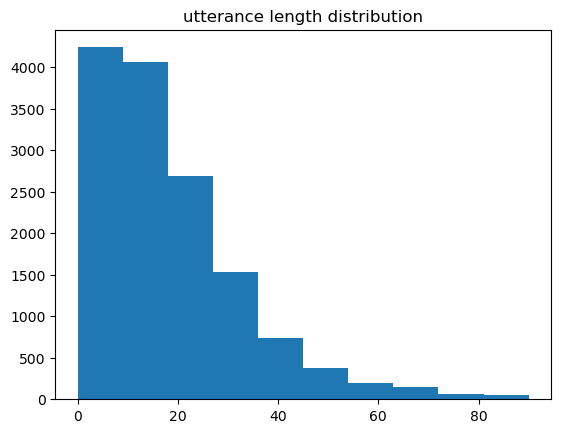

Median utterance length: 30.0
Mean utterance length: 50.61839035769829
There are 118 subjects in our dataset
The average subject has around 43.59322033898305 utterances



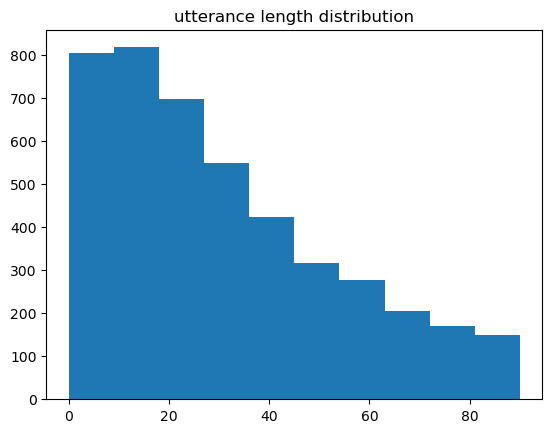

In [50]:
data_summary(dfu)
data_summary(df)

### Align attention variables with utterances

__Making script to check for overlaping sequences__

In [7]:
def plot_overlap(a0, b0, a1, b1):

    t = [[a0, b0],[a1, b1],[1,1],[2,2]]

    plt.title(f"overlap: {overlap(t[0][0],t[0][1],t[1][0],t[1][1])}")
    plt.xlim(0, max(b0,b1)), plt.ylim(0, 4)
    plt.plot(t[0],t[2])
    plt.plot(t[1],t[3])
    plt.show()

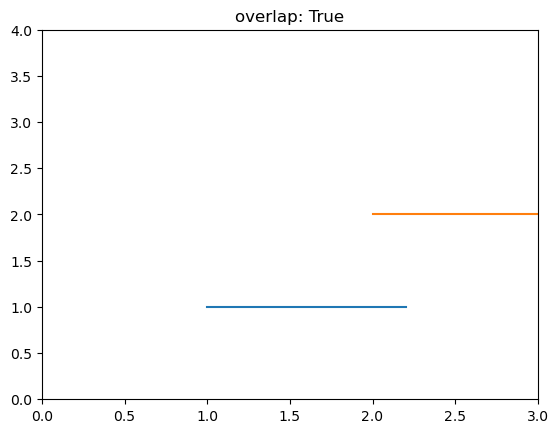

In [38]:
plot_overlap(1,2.2, 2, 3)

__Loading the matlab Join Attention Data__

In [14]:
JA = scipy.io.loadmat(r"M:\experiment_12\included\__20151217_16963\derived\cevent_eye_joint-attend_both.mat")
JA = JA["sdata"]["data"][0][0].tolist()
JA

[[31.54, 44.599999999999994, 20.0],
 [50.9, 53.669999999999995, 20.0],
 [54.9, 56.669999999999995, 25.0],
 [64.77, 67.13999999999999, 6.0],
 [67.74, 70.13999999999999, 10.0],
 [70.8, 73.13999999999999, 6.0],
 [76.94, 77.86999999999999, 10.0],
 [84.07000000000001, 85.69999999999999, 18.0],
 [88.07000000000001, 88.63999999999999, 10.0],
 [89.97, 91.03999999999999, 10.0],
 [91.44, 92.57, 6.0],
 [97.4, 98.0, 2.0],
 [105.8, 108.44, 23.0],
 [110.57000000000001, 113.66999999999999, 15.0],
 [115.24000000000001, 117.5, 15.0],
 [120.2, 120.77, 15.0],
 [123.57000000000001, 130.64, 15.0],
 [135.64000000000001, 138.6, 15.0],
 [156.44, 168.54, 20.0],
 [174.17000000000002, 177.73999999999998, 20.0],
 [180.8, 181.84, 15.0],
 [183.27, 184.76999999999998, 15.0],
 [188.9, 189.64, 14.0],
 [198.07, 200.67, 14.0],
 [211.3, 220.07, 18.0],
 [221.4, 222.79999999999998, 18.0],
 [223.8, 227.04, 18.0],
 [231.97, 232.5, 15.0],
 [243.14000000000001, 249.4, 21.0],
 [251.14000000000001, 253.5, 21.0],
 [255.07, 255.9,

__Test aligning variables and changing dataframe values__ 

In [52]:
dfu = pd.read_csv("exp_12_15_351_utterances.csv")
dfu["attention"] = 0
dft = dfu[dfu["sub"] == "20151217_16963"].copy()
JA_list = JA

for i in dft.index:
    u1, u2 = dft.iloc[i][2:4]
    
    attention = align(u1, u2, JA_list)
    
    dft.loc[i, "attention"] = attention
dft["attention"].unique()

array([0, 1], dtype=int64)

__Align JA for all subjects__

In [45]:
dfu = pd.read_csv("exp_12_15_351_utterances.csv")
dfu["JA"] = 0

for var_sub in dfu["sub"].unique():
    var_exp = dfu[dfu["sub"] == var_sub].iloc[1, 0]
    
    var_string = f"M:\\experiment_{int(var_exp)}\\included\\__{var_sub}\\derived\\cevent_eye_joint-attend_both.mat"
    
    try: 
        JA = scipy.io.loadmat(var_string)
        JA = JA["sdata"]["data"][0][0].tolist()
        
        dfs = dfu[dfu["sub"] == var_sub]
        
        for i in dfs.index:
            u1, u2 = dfu.iloc[i, 2:4]
            attention = align(u1, u2, JA) 
            dfu.iloc[i, -1] = attention
            
    except Exception as e:
        #print(traceback.format_exc())
        print(e)

        mask = dfu["sub"] == var_sub
        # this selects only the rows of interest 
        dfu.loc[dfu["sub"] == var_sub, "JA"] = np.nan

[Errno 2] No such file or directory: 'M:\\experiment_12\\included\\__20160225_17406\\derived\\cevent_eye_joint-attend_both.mat'
[Errno 2] No such file or directory: 'M:\\experiment_12\\included\\__20171012_19694\\derived\\cevent_eye_joint-attend_both.mat'
[Errno 2] No such file or directory: 'M:\\experiment_15\\included\\__20180725_21960\\derived\\cevent_eye_joint-attend_both.mat'
